In [2]:
data_path = "../data/images"
label_path = "../data/labels"  

# read dataset
import os
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

/root/anaconda3/envs/python3.7/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Augmentation
INPUT_HEIGHT = 224
INPUT_WIDTH = 224

In [4]:
TRAIN_PATH = "../data/split/test/images"

In [76]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms

def collate_fn(batch):
    return tuple(zip(*batch))

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        print("Transform: ", transform)
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        original_size = image.size

        # Load corresponding label
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)
        
        # Read YOLO format labels (class x_center y_center width height)
        boxes = []
        classes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x, y, w, h = map(float, line.strip().split())
                    boxes.append([x, y, w, h])
                    classes.append(class_id)
        with open('debug-before.log', 'a') as f:
            f.write(f"BBOX before transform: {boxes} with {image.size}\n")

        boxes = torch.tensor(boxes, dtype=torch.float16)
        classes = torch.tensor(classes, dtype=torch.int64)
        
        if self.transform:
            image = self.transform(image)
            if boxes.numel() > 0:
                boxes[:, 0] = boxes[:, 0] * original_size[0]
                boxes[:, 1] = boxes[:, 1] * original_size[1]
                boxes[:, 2] = boxes[:, 2] * original_size[0]
                boxes[:, 3] = boxes[:, 3] * original_size[1]

                x_center = boxes[:, 0]
                y_center = boxes[:, 1]
                width = boxes[:, 2]
                height = boxes[:, 3]
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                boxes = torch.stack([x_min, y_min, x_max, y_max], dim=1)

                # Resize bounding boxes to match the resized image
                new_size = image.size()[1:]  # (C, H, W) -> (H, W)
                boxes[:, [0, 2]] = boxes[:, [0, 2]] * (new_size[1] / original_size[0])
                boxes[:, [1, 3]] = boxes[:, [1, 3]] * (new_size[0] / original_size[1]) 
        return image, {'boxes': boxes, 'labels': classes}

In [71]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class faster_rcnn:
    def __init__(self, num_classes):
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    def forward(self, images, targets=None):
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
        
        Returns:
            result (list[Dict[Tensor]]): the output from the model
        """
        if self.training:
            return self.model(images, targets)
        else:
            return self.model(images)

    def train(self, mode=True):
        self.training = mode
        self.model.train(mode)

    def eval(self):
        self.train(False)

In [7]:
!pip install torchmetrics

In [65]:
import torch
import torch.nn.functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate_model(model, val_loader, device):
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model.forward(images)  # model(images) in eval mode

            pred_dicts = []
            for p in preds:
                pred_dicts.append({
                    "boxes": p["boxes"].detach().cpu(),
                    "scores": p["scores"].detach().cpu(),
                    "labels": p["labels"].detach().cpu(),
                })

            target_dicts = []
            for t in targets:
                target_dicts.append({
                    "boxes": t["boxes"].detach().cpu(),
                    "labels": t["labels"].detach().cpu(),
                })
            
            metric.update(pred_dicts, target_dicts)

    results = metric.compute()
    return results["map"]

def train_model(train_loader, val_loader, device, num_classes=5, epochs=10, batch_size=1, eval_every=1):
    # Load pretrained yolov5n
    
    model = faster_rcnn(num_classes)
    params = [p for p in model.model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        i = 0
        for images, targets in train_loader:
            i += 1
            # images: [batch, 3, H, W]
            # targets: list of dicts with {'boxes': [B,4], 'labels': [B]} in YOLO format
            # images = images.to(device)
            
            # Forward pass
            print(f"Full boxes in iter {i}: and size {len(targets)}")
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss = model.forward(images, targets)
            losses = sum(loss for loss in loss.values())
            # loss = detection_loss(preds, {
            #     'boxes': targets['boxes'],
            #     'conf': torch.ones_like(targets['labels'], dtype=torch.float32),
            #     'labels': targets['labels']
            # }, num_classes)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            print(f"Epoch [{epoch+1}/{epochs}], Iteration [{i}/{len(train_loader)}] Loss: {losses}")
            
        if eval_every > 0 and (epoch + 1) % eval_every == 0:
            mean_ap = evaluate_model(model, val_loader, device)
            print(f"mAP: {mean_ap}")
    torch.save(model.model.state_dict(), 'faster-rcnn.pt')
    print("Training complete.")

In [77]:

# Usage example
TRAIN_PATH = "../data/split/test"
BATCH_SIZE = 8
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Create dataset and dataloader
train_dataset = CustomDataset(
    root_dir=TRAIN_PATH,
    transform=transforms

)
val_dataset = CustomDataset(
    root_dir=TRAIN_PATH,
    transform=transforms

)

Transform:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Transform:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


test a sample

22
Image Size:  torch.Size([3, 224, 224])
{'boxes': tensor([[ 63.8438,   3.5117,  95.7500,  50.2188],
        [ 32.9688, 167.0000,  49.7812, 190.7500],
        [ 32.4688,   1.9307, 138.7500, 217.5000]], dtype=torch.float16), 'labels': tensor([0, 1, 3])}


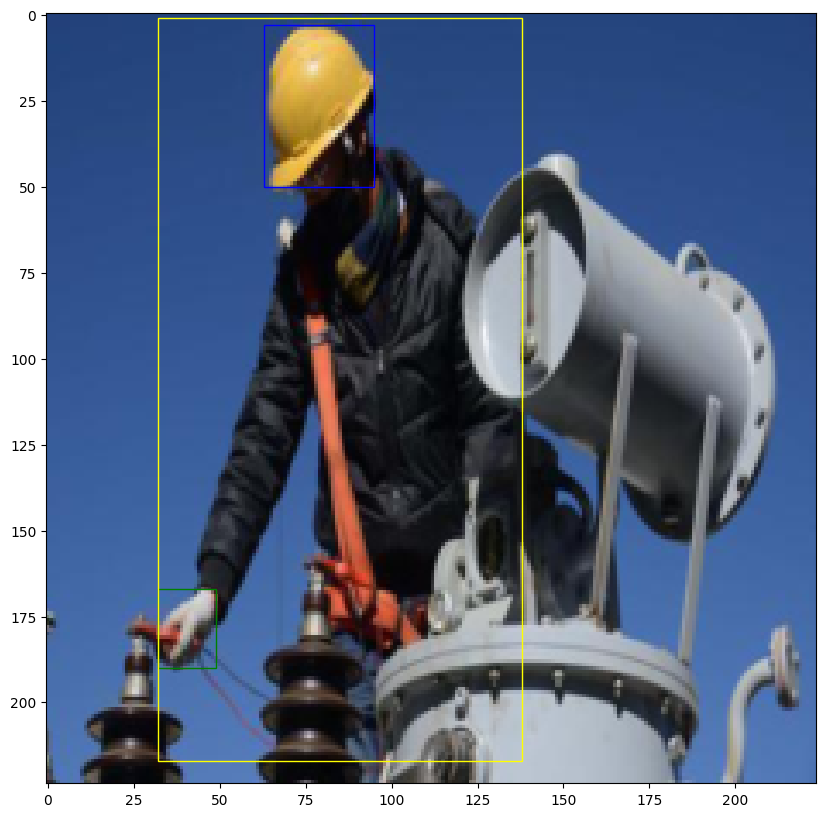

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print(len(train_dataset))
img, target = train_dataset[1]
print("Image Size: ", img.size())
print(target)

img = img.cpu().numpy().transpose(1, 2, 0)
col_dict = {1:'blue', 2:'green', 3:'purple', 4:'yellow', 5:'orange', 6:'pink'}

plt.figure(figsize=(10, 10))
plt.imshow(img)
# Get the current reference
ax = plt.gca()

for i in range(len(target['boxes'])):
    x1, x2, x3, x4 = map(int, target['boxes'][i].tolist())
    width = x3 - x1
    height = x4 - x2
    # Create a Rectangle patch
    color = col_dict[(int(target['labels'][i]) + 1) % len(col_dict.keys())]
    rect = patches.Rectangle((x1,x2),width,height,linewidth=1,edgecolor=color,facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

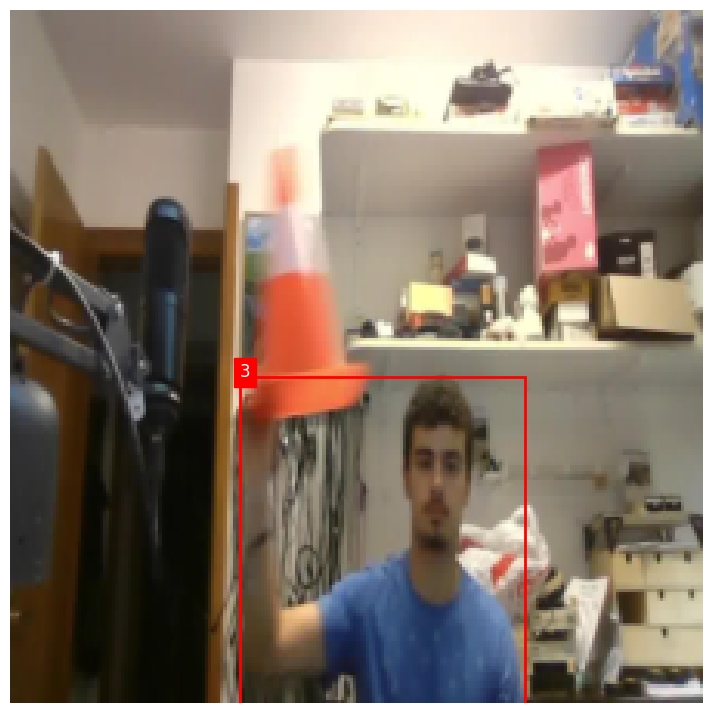

In [79]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn,
    pin_memory=True
) # return a list of (image, target) pairs

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn,
    pin_memory=True
)

# check a sample
id = 5
images, targets = next(iter(train_loader))
img = images[id].cpu().numpy().transpose(1, 2, 0)
target = targets[id]
def visualize_sample(image, target):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label in zip(target['boxes'], target['labels']):
        box = box.cpu().numpy()
        label = label.cpu().numpy()
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(box[0], box[1], label, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()

# Visualize the first image and its targets from the train_loader
visualize_sample(img, target)
# # Train
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_model(train_loader, val_loader, device, num_classes=5, epochs=2, batch_size=BATCH_SIZE, eval_every=2)

In [81]:
def get_preprocessed_data(data_path):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
    ])
    data = CustomDataset(
        root_dir=data_path,
        transform=transform
    )
    return data

In [84]:
from torchvision import transforms

TRAIN_PATH = "../data/split/test"
VAL_PATH = "../data/split/test"
BATCH_SIZE = 8

# Create dataset and dataloader
train_dataset = get_preprocessed_data(TRAIN_PATH)
val_dataset = get_preprocessed_data(TRAIN_PATH)

print(len(train_dataset))
img, target = train_dataset[0]
print("Image Size: ", img.size())
print(target)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn,
    pin_memory=True
)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(train_loader, val_loader, device, num_classes=5, epochs=10, batch_size=BATCH_SIZE, eval_every=2)

Transform:  Compose(
    Resize(size=(640, 640), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Transform:  Compose(
    Resize(size=(640, 640), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
22
Image Size:  torch.Size([3, 640, 640])
{'boxes': tensor([[365.5000,  42.5000, 460.5000,  99.5000],
        [  8.0000, 433.0000, 122.0000, 583.0000],
        [ 70.0000, 364.0000, 146.0000, 413.0000],
        [529.0000,  33.0000, 626.0000,  92.0000],
        [160.5000, 447.0000, 306.5000, 569.0000],
        [333.0000, 118.0000, 489.0000, 213.0000],
        [524.0000, 121.0000, 634.0000, 211.0000]], dtype=torch.float16), 'labels': tensor([0, 2, 0, 0, 2, 2, 2])}


/root/anaconda3/envs/python3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Full boxes in iter 1: and size 8


: 

In [1]:
def show_preds(image, preds):
    boxes = preds[0]['boxes']
    labels = preds[0]['labels']
    scores = preds[0]['scores']
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i in range(boxes.shape[0]):
        if scores[i] < 0.1:
            continue
        box = boxes[i].cpu().numpy()
        label = labels[i].cpu().numpy()
        score = scores[i].cpu().numpy()
        print(box, label, score)
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        cv2.putText(image, f"{label} {score:.2f}", (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    plt.imshow(image)
    plt.show()
    
def inference(device, pretrain="faster-rcnn.pt", src_path=""):
    model = faster_rcnn(5)
    model.model.load_state_dict(torch.load(pretrain))
    model.model.to(device)
    model.eval()
    with torch.no_grad():
        image = Image.open(src_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        preds = model.forward(image)
    show_preds(image, preds)
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference(device, pretrain="faster-rcnn.pt", src_path="test.jpg")

NameError: name 'transforms' is not defined